In [25]:
# import modules
from __future__ import absolute_import, division, print_function, unicode_literals

import subprocess
# hide future deprecation warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from time import time
import numpy as np
import random
import cv2

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
#tf.disable_v2_behavior()
#tf.enable_eager_execution()
#print("Eager execution: {}".format(tf.executing_eagerly()))


# keras stuff
from keras.models import Model
#from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Activation, Dense, Input, Lambda, Concatenate, Add
from keras import losses, regularizers, initializers, activations
from keras import optimizers as opt
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.utils.generic_utils import get_custom_objects
from tensorflow.compat.v1.keras import backend as K
from sklearn.model_selection import train_test_split
import os
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import transforms
from tifffile import imread

from copy import deepcopy as dp

In [26]:
tf_config =  tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

# set global variables
cwd = os.getcwd()
os.chdir(cwd)
sess = tf.InteractiveSession()
checkpoint_file = "data_covid4class.h5"

C:\Users\natas\anaconda3\envs\py36\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


TiffPage 0: UnicodeDecodeError: 'utf-16-le' codec can't decode bytes in position 472-473: illegal UTF-16 surrogate


(198, 2, 512, 512)


<IPython.core.display.Javascript object>


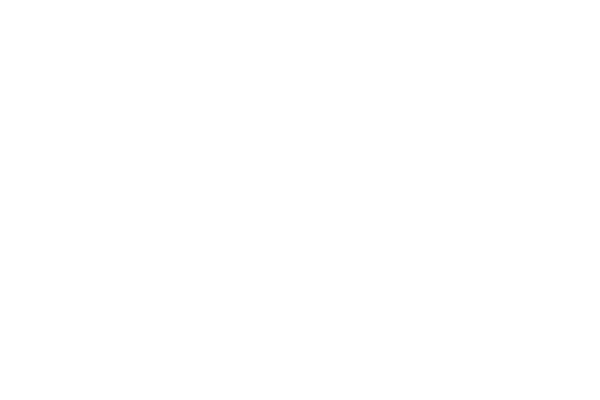

In [27]:
#import samson=
datadump = imread('Jasper/stack.tif')
print(datadump.shape)

fig01 = plt.figure(figsize=(6,4))
plt.imshow(datadump[0,1,:,:],cmap='jet')

datadump = datadump[:,1,:,:]
datadump = datadump.T

In [32]:
# abun = datadump['A'].T #  ground-truth (location inside the simplex), % of each feature: must sum up to 1
# feat = datadump['M'].T - 0.31 # ground-truth spectra for the features

# print(np.amax(feat), np.amin(feat))

#number of pixels (samples N) = 9052 (95x95)
#number of features (channels F) = 156
#number of end-member (K) = 3

# raw_data = np.matmul(abun, feat)

# pre-processing raw-data to satisfy activation function of tanh
rmin,rmax = np.amin(datadump), np.amax(datadump)
datadump = (datadump - rmin)/(rmax-rmin) -0.5

# reshape HSI image into (samples/pixels) X # of frequencies
raw_data = np.reshape(datadump,[datadump.shape[0]*datadump.shape[1],datadump.shape[2]])
print(raw_data.shape)


spec_len = raw_data.shape[1]
# Natasha will confirm from domain knowledge
num_mem = 4 # number of assumed classes or pure end-members
num_samp = raw_data.shape[0]

# train_data, test_data = train_test_split(raw_data, test_size=0.001, random_state=42)
train_data = raw_data
inp_shape = spec_len
out_shape = num_mem*(1 + spec_len)
print(train_data.shape, spec_len, num_mem, num_samp, inp_shape, out_shape)

(262144, 198)
(262144, 198) 198 4 262144 198 796


<IPython.core.display.Javascript object>


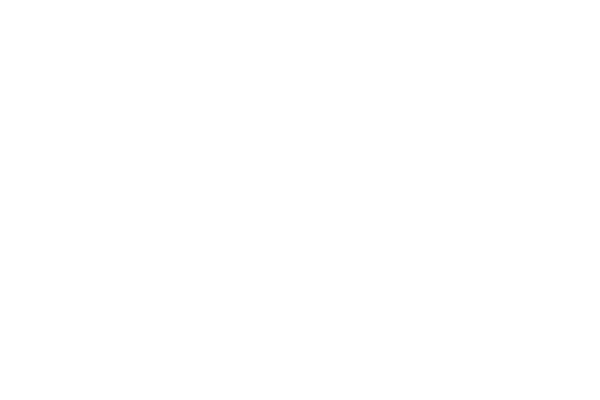

In [29]:
fig02 = plt.figure(figsize=(6,4))
plt.plot(datadump[10,0,:])
plt.show()

## One Neuron Network

* Since linear separability is required between the features one neuron is sufficient

In [33]:
# define a smoother function than relu
def custact(x):
    return (K.tanh(x)+1.)/2.

get_custom_objects().update({'custact': Activation(custact)})

def dense_net_min(act_f):
      
    inputs = Input(shape=(inp_shape,))
    layer_5 = Dense(num_mem, activation='relu', use_bias=False, name='weig')(inputs) 
    layer_o = Dense(spec_len, activation=act_f,use_bias=False, name='inva')(layer_5)
    prediction = layer_o

    dense_min = Model(inputs=inputs, outputs=prediction)
    
    print('Model loaded.')

    return dense_min

In [34]:
def min_loss(ytrue, ypred):
    
    batch = K.shape(dense_min.input)[0]
        
    mat_A = dense_min.get_layer('inva').trainable_weights[0]
    
    vec_s = dense_min.get_layer('weig').output
    
#     print(mat_A,vec_s)
    
    err1 = K.sum(K.square(dense_min.input-ypred),axis=1)
        
    err2 = K.square(K.sum(vec_s,axis=1) - 1.)
        
    btb = tf.matmul(mat_A,tf.transpose(mat_A,[1,0]))
    
    btb1, btbl = tf.split(btb,[1,num_mem-1],axis=0)
    
    btbl = btbl - btb1
    
    btbn = K.concatenate([K.ones_like(btb1),btbl],axis=0)
    
    err3 = 0.05*(tf.linalg.det(btbn + 0.0001*tf.Variable(lambda:K.eye(num_mem))))
        
    loss = K.mean(err1 + err2) + tf.divide(err3,tf.cast(batch,dtype=tf.float32))

    return loss

def dum_loss(ytrue, ypred):
    
    loss = K.mean(K.sum(K.square(ypred-dense_min.input),axis=1))

    return loss

In [35]:
print('-' * 30)
print('Creating and compiling model...')
print('-' * 30)

act_f = 'tanh'

# act_f = custact

dense_min = dense_net_min(act_f)

dense_min.summary()

------------------------------
Creating and compiling model...
------------------------------
Model loaded.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 198)               0         
_________________________________________________________________
weig (Dense)                 (None, 4)                 792       
_________________________________________________________________
inva (Dense)                 (None, 198)               792       
Total params: 1,584
Trainable params: 1,584
Non-trainable params: 0
_________________________________________________________________


In [38]:
opt = Adam(learning_rate=0.001)
dense_min.compile(optimizer=opt, loss=min_loss, metrics=[dum_loss])

dense_min.load_weights(checkpoint_file)


print('Fitting Model...')
print('-' * 30)
init = tf.global_variables_initializer()
sess.run(init)
model_checkpoint = ModelCheckpoint(checkpoint_file, monitor='loss', verbose=1, save_best_only=True, mode='min')



history = dense_min.fit(train_data, train_data, validation_split=0.01, validation_steps=1, steps_per_epoch=898, \
                        epochs=30, shuffle=True, callbacks = [model_checkpoint])



In [40]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d

#out = dense_min.predict(train_data)

intermed_inva = K.eval(dense_min.get_layer('inva').trainable_weights[0])

batch = 32

def visualize_layer(layer_name,data):
  
    layer_output=dense_min.get_layer(layer_name).output
 
    intermediate_model= Model(inputs=dense_min.input,outputs=layer_output)
 
    intermediate_prediction=intermediate_model.predict(data,batch_size=batch)
    
    return intermediate_prediction

intermed = visualize_layer('weig',train_data)

print(np.sum(intermed[1000,:]), intermed[1000,:])

# fig3 = plt.figure(figsize=(6,4))
# ax3 = fig3.add_subplot(111,projection='3d')
# ax3.scatter(intermed[:,0],intermed[:,1],intermed[:,2],c='r')

0.9868157 [0.        0.        0.0099569 0.9768588]


In [ ]:
print(train_data)

<IPython.core.display.Javascript object>


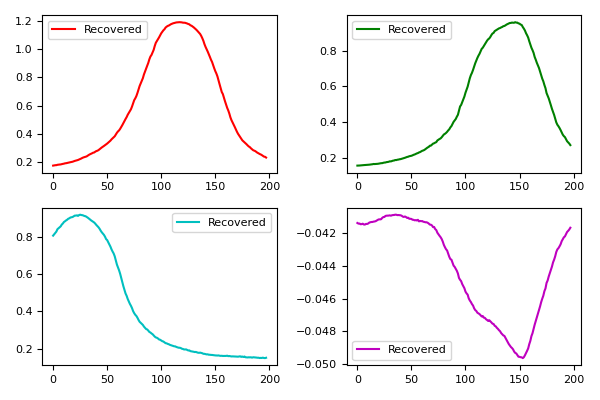

In [41]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(221)
l1, = ax1.plot(intermed_inva[0,:]+0.5,c='r')
# l2, = ax1.plot(feat[0,:]+0.5,c='k',linestyle='--')
plt.legend([l1], ['Recovered'], prop={"size":8},markerscale=6, loc='best')
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.tick_params(axis='both', which='minor', labelsize=8)
# ax1.set_ylim([0.1, 0.82])
ax2 = fig.add_subplot(222)
l3, = ax2.plot(intermed_inva[1,:]+0.5,c='g')
# l4, = ax2.plot(feat[1,:]+0.5,c='k',linestyle='--')
plt.legend([l3], ['Recovered'], prop={"size":8},markerscale=6, loc='best')
ax2.tick_params(axis='both', which='major', labelsize=8)
ax2.tick_params(axis='both', which='minor', labelsize=8)
# ax2.set_ylim([0.1, 0.82])
ax3 = fig.add_subplot(223)
l5, = ax3.plot(intermed_inva[2,:]+0.5,c='c')
# l6, = ax3.plot(feat[2,:]+0.5,c='k',linestyle='--')
plt.legend([l5], ['Recovered'], prop={"size":8},markerscale=6, loc='best')
ax3.tick_params(axis='both', which='major', labelsize=8)
ax3.tick_params(axis='both', which='minor', labelsize=8)
# ax3.set_ylim([0.1, 0.82])
ax4 = fig.add_subplot(224)
l5, = ax4.plot(intermed_inva[3,:]+0.5,c='m')
# l6, = ax4.plot(feat[3,:]+0.5,c='k',linestyle='--')
plt.legend([l5], ['Recovered'], prop={"size":8},markerscale=6, loc='best')
ax4.tick_params(axis='both', which='major', labelsize=8)
ax4.tick_params(axis='both', which='minor', labelsize=8)
# ax4.set_ylim([0.1, 0.82])
plt.tight_layout()

<IPython.core.display.Javascript object>


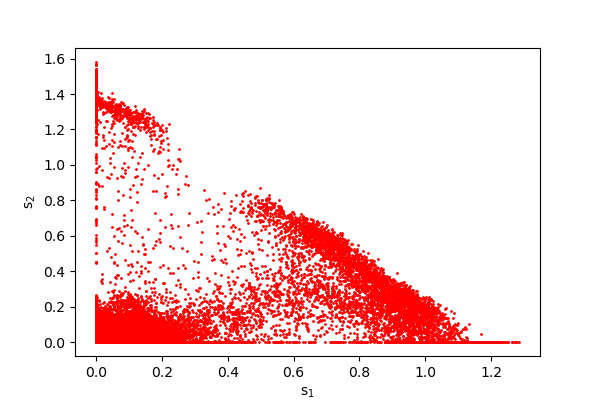

Text(0, 0.5, 's$_2$')

In [42]:
fig4 = plt.figure(figsize=(6,4))
ax4 = fig4.add_subplot(111)
# ax4 = fig4.add_subplot(111)
ax4.scatter(intermed[:,0],intermed[:,1],c='r',s=1)
ax4.set_xlabel('s$_1$', fontsize=10)
ax4.set_ylabel('s$_2$', fontsize=10)
# ax4.set_zlabel('s$_3$', fontsize=10)
# ax4.view_init(30, 45)

<IPython.core.display.Javascript object>


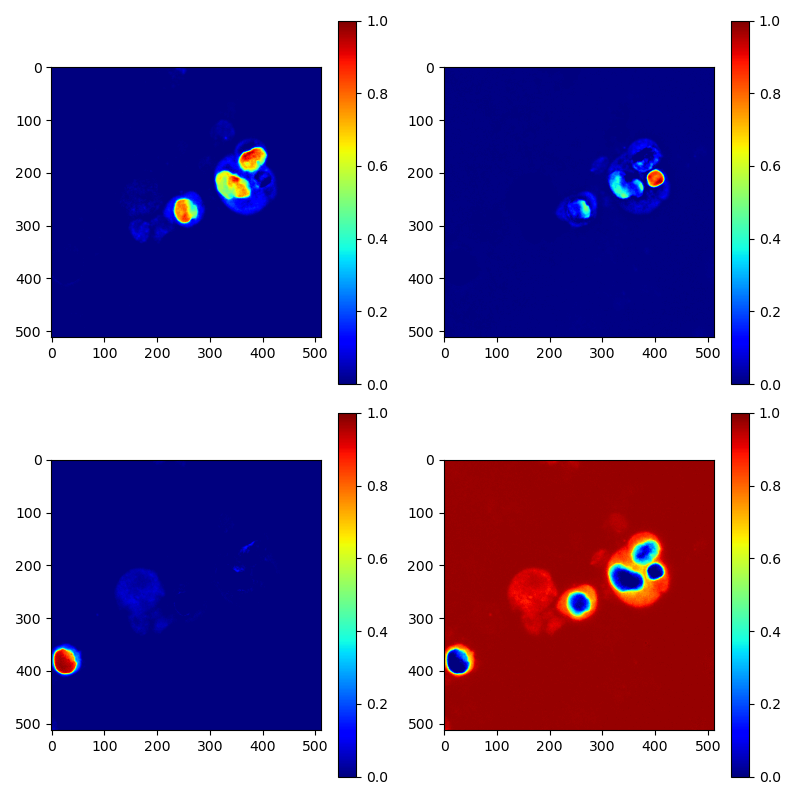

In [43]:
sha = 512

from matplotlib import cm
abun1 = np.reshape(intermed[:,0], [sha,sha]).T
abun2 = np.reshape(intermed[:,1], [sha,sha]).T
abun3 = np.reshape(intermed[:,2], [sha,sha]).T
abun4 = np.reshape(intermed[:,3], [sha,sha]).T


# norm = cm.colors.Normalize(vmax=abs(Z).max(), vmin=-abs(Z).max())
figpt1 = plt.figure(figsize=(8,8))
axpt1 = figpt1.add_subplot(221)
axpt1.imshow(abun1,cmap='jet')
axpt2 = figpt1.add_subplot(222)
axpt2.imshow(abun2,cmap='jet')
axpt3 = figpt1.add_subplot(223)
axpt3.imshow(abun3,cmap='jet')
axpt4 = figpt1.add_subplot(224)
axpt4.imshow(abun4,cmap='jet')


figpt1.colorbar(cm.ScalarMappable(cmap='jet'),ax=axpt1)
figpt1.colorbar(cm.ScalarMappable(cmap='jet'),ax=axpt2)
figpt1.colorbar(cm.ScalarMappable(cmap='jet'),ax=axpt3)
figpt1.colorbar(cm.ScalarMappable(cmap='jet'),ax=axpt4)

plt.tight_layout()
# plt.title('Top: Recovered, Bottom:True')
# plt.savefig('abun_samson.pdf')